### Time Series Forecasting using LSTM

In [33]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from convert_columns_to_floats import *

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [34]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [35]:
orig_df = pd.read_csv('/Users/faymajidelhassan/Downloads/Master project /Data/Weather/forecasts/open_weather.csv') 
df = orig_df.copy() 
print(f'Size of the dataset: {df.shape} \n')  
print() 
display(df.head(5))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

Size of the dataset: (63132, 9) 




,timestamp,temperature,humidity,pressure,cloud_cover,wind_speed,wind_direction,weather_code,poprecipitation
0,2021-04-30 22:00:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
1,2021-04-30 22:15:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
2,2021-04-30 22:30:00,"[15.36, 15.56, 15.2, 14.65, 13.78, 12.82, 12.0...","[69, 67, 69, 72, 76, 81, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
3,2021-04-30 22:45:00,"[15.28, 15.47, 15.13, 14.6, 13.74, 12.8, 12.08...","[73, 72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
4,2021-04-30 23:00:00,"[15.48, 15.13, 14.6, 13.75, 12.8, 12.08, 13.32...","[72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 56, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1011, 101...","[0, 17, 40, 43, 60, 81, 85, 86, 100, 100, 100,...","[1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84, 0.54,...","[242, 243, 221, 230, 223, 231, 229, 221, 239, ...","{'id': [800, 801, 802, 802, 803, 803, 804, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.2..."


In [36]:
# switch forecasts sequences from string to np array
import json
for for_val in ['temperature', 'humidity', 'pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'poprecipitation']:
        df[for_val] = df[for_val].map(lambda x: np.array(json.loads(x)), na_action='ignore')
df

,temperature,humidity,pressure,cloud_cover,wind_speed,wind_direction,weather_code,poprecipitation
timestamp,,,,,,,,
2021-04-30 22:00:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 22:15:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 22:30:00,"[15.36, 15.56, 15.2, 14.65, 13.78, 12.82, 12.0...","[69, 67, 69, 72, 76, 81, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 22:45:00,"[15.28, 15.47, 15.13, 14.6, 13.74, 12.8, 12.08...","[73, 72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 23:00:00,"[15.48, 15.13, 14.6, 13.75, 12.8, 12.08, 13.32...","[72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 56, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1011, 101...","[0, 17, 40, 43, 60, 81, 85, 86, 100, 100, 100,...","[1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84, 0.54,...","[242, 243, 221, 230, 223, 231, 229, 221, 239, ...","{'id': [800, 801, 802, 802, 803, 803, 804, 804...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2023-02-17 11:45:00,"[14.06, 14.7, 14.38, 14.18, 13.6, 12.12, 10.1,...","[53, 51, 52, 53, 56, 63, 72, 75, 78, 79, 81, 8...","[1026, 1026, 1026, 1026, 1025, 1025, 1026, 102...","[2, 0, 8, 19, 30, 39, 55, 60, 64, 77, 82, 75, ...","[2.9, 3.28, 3.52, 3.39, 3.19, 3.24, 3.03, 3.0,...","[238, 240, 242, 245, 241, 235, 235, 236, 237, ...","{'id': [800, 800, 800, 801, 802, 802, 803, 803...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2023-02-17 12:00:00,"[14.8, 14.46, 14.24, 13.64, 12.14, 10.1, 9.32,...","[51, 52, 53, 56, 63, 72, 75, 78, 79, 81, 83, 8...","[1026, 1026, 1026, 1025, 1025, 1026, 1026, 102...","[0, 8, 19, 30, 39, 55, 60, 64, 77, 82, 75, 65,...","[3.28, 3.52, 3.39, 3.19, 3.24, 3.03, 3.0, 2.92...","[240, 242, 245, 241, 235, 235, 236, 237, 243, ...","{'id': [800, 800, 801, 802, 802, 803, 803, 803...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2023-02-17 12:15:00,"[15.76, 15.1, 14.58, 13.72, 11.78, 9.18, 8.67,...","[48, 51, 55, 59, 67, 78, 79, 80, 81, 84, 86, 8...","[1025, 1025, 1025, 1025, 1025, 1026, 1026, 102...","[0, 16, 33, 45, 62, 78, 81, 90, 90, 71, 61, 52...","[4.23, 4.42, 3.79, 3.71, 3.5, 3.24, 3.39, 3.48...","[242, 242, 242, 239, 236, 234, 230, 236, 243, ...","{'id': [800, 801, 802, 802, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [37]:
# pick one meteo variable
meas = 'temperature'
df_for = df.loc[:,[meas]]
df_for

,temperature
timestamp,
2021-04-30 22:00:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0..."
2021-04-30 22:15:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0..."
2021-04-30 22:30:00,"[15.36, 15.56, 15.2, 14.65, 13.78, 12.82, 12.0..."
2021-04-30 22:45:00,"[15.28, 15.47, 15.13, 14.6, 13.74, 12.8, 12.08..."
2021-04-30 23:00:00,"[15.48, 15.13, 14.6, 13.75, 12.8, 12.08, 13.32..."
...,...
2023-02-17 11:45:00,"[14.06, 14.7, 14.38, 14.18, 13.6, 12.12, 10.1,..."
2023-02-17 12:00:00,"[14.8, 14.46, 14.24, 13.64, 12.14, 10.1, 9.32,..."
2023-02-17 12:15:00,"[15.76, 15.1, 14.58, 13.72, 11.78, 9.18, 8.67,..."


In [38]:
# pick one meteo variable
measP = 'poprecipitation'
df_forP = df.loc[:,[measP]]
df_forP

,poprecipitation
timestamp,
2021-04-30 22:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 22:15:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 22:30:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 22:45:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2021-04-30 23:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
2023-02-17 11:45:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2023-02-17 12:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2023-02-17 12:15:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [39]:
#unpack forecasts
df_for.dropna(how='any',inplace=True)
df_for_cols_ext = [meas+'_forecast+'+str(i)+'h' for i in range(0,len(df_for[meas].values[0]))]
df_for = pd.DataFrame(index=df_for.index, data=df_for[meas].to_list(), columns=df_for_cols_ext)
df_for = df_for.asfreq('1H')
df_for

,temperature_forecast+0h,temperature_forecast+1h,temperature_forecast+2h,temperature_forecast+3h,temperature_forecast+4h,temperature_forecast+5h,temperature_forecast+6h,temperature_forecast+7h,temperature_forecast+8h,temperature_forecast+9h,...,temperature_forecast+38h,temperature_forecast+39h,temperature_forecast+40h,temperature_forecast+41h,temperature_forecast+42h,temperature_forecast+43h,temperature_forecast+44h,temperature_forecast+45h,temperature_forecast+46h,temperature_forecast+47h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-30 22:00:00,15.56,15.26,14.84,14.20,13.18,12.13,12.08,13.32,15.37,17.31,...,20.19,19.90,19.88,19.23,18.01,16.32,14.85,13.63,11.86,9.92
2021-04-30 23:00:00,15.48,15.13,14.60,13.75,12.80,12.08,13.32,15.37,17.31,18.82,...,19.90,19.88,19.23,18.01,16.32,14.85,13.63,11.86,9.92,9.45
2021-05-01 00:00:00,15.48,15.04,14.32,13.47,12.76,13.32,15.37,17.31,18.82,20.65,...,19.88,19.23,18.01,16.32,14.85,13.63,11.86,9.92,9.45,9.05
2021-05-01 01:00:00,15.24,14.71,14.00,13.34,13.70,15.37,17.31,18.82,20.65,22.03,...,19.23,18.01,16.32,14.85,13.63,11.86,9.92,9.45,9.05,8.76
2021-05-01 02:00:00,14.00,13.70,13.32,13.68,14.93,17.12,18.91,20.93,21.88,22.30,...,16.91,14.89,11.37,10.06,9.55,9.06,8.65,8.27,8.23,7.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,5.30,5.90,7.19,9.01,10.96,13.08,13.40,12.87,11.47,10.10,...,8.19,7.93,7.67,7.44,7.25,7.14,7.22,7.14,7.24,7.79
2023-02-17 09:00:00,9.43,9.55,10.25,11.20,12.35,13.40,12.87,11.47,10.10,9.32,...,7.93,7.67,7.44,7.25,7.14,7.22,7.14,7.24,7.79,9.06
2023-02-17 10:00:00,10.79,10.93,11.43,12.16,12.88,12.87,11.47,10.10,9.32,8.66,...,7.67,7.44,7.25,7.14,7.22,7.14,7.24,7.79,9.06,10.55


In [40]:
#unpack forecasts
df_forP.dropna(how='any',inplace=True)
df_for_cols_ext = [measP+'_forecast+'+str(i)+'h' for i in range(0,len(df_forP[measP].values[0]))]
df_forP = pd.DataFrame(index=df_forP.index, data=df_forP[measP].to_list(), columns=df_for_cols_ext)
df_forP = df_forP.asfreq('1H')
df_forP

,poprecipitation_forecast+0h,poprecipitation_forecast+1h,poprecipitation_forecast+2h,poprecipitation_forecast+3h,poprecipitation_forecast+4h,poprecipitation_forecast+5h,poprecipitation_forecast+6h,poprecipitation_forecast+7h,poprecipitation_forecast+8h,poprecipitation_forecast+9h,...,poprecipitation_forecast+38h,poprecipitation_forecast+39h,poprecipitation_forecast+40h,poprecipitation_forecast+41h,poprecipitation_forecast+42h,poprecipitation_forecast+43h,poprecipitation_forecast+44h,poprecipitation_forecast+45h,poprecipitation_forecast+46h,poprecipitation_forecast+47h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.18,0.22,0.21,0.29,0.33,0.37,0.37,0.38,0.34,0.34
2021-04-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.22,0.21,0.29,0.33,0.37,0.37,0.38,0.34,0.34,0.34
2021-05-01 00:00:00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.21,0.29,0.33,0.37,0.37,0.38,0.34,0.34,0.34,0.34
2021-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.29,0.33,0.37,0.37,0.38,0.34,0.34,0.34,0.34,0.34
2021-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.43,0.48,0.58,0.50,0.46,0.45,0.45,0.45,0.45,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-02-17 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-02-17 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [41]:
dfT=df_for.fillna(method='ffill')
dfP = df_forP.fillna(method='ffill')



In [42]:
# reduce memory usage
dfT= reduce_mem_usage(dfT)
dfP= reduce_mem_usage(dfP)

Mem. usage decreased to  1.57 Mb (73.5% reduction)
Mem. usage decreased to  1.57 Mb (73.5% reduction)


In [43]:
Mu_meas ='humidity' 
df_multi = df.loc[:,[Mu_meas]]
df_multi

,humidity
timestamp,
2021-04-30 22:00:00,"[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5..."
2021-04-30 22:15:00,"[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5..."
2021-04-30 22:30:00,"[69, 67, 69, 72, 76, 81, 85, 81, 73, 66, 61, 5..."
2021-04-30 22:45:00,"[73, 72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 5..."
2021-04-30 23:00:00,"[72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 56, 5..."
...,...
2023-02-17 11:45:00,"[53, 51, 52, 53, 56, 63, 72, 75, 78, 79, 81, 8..."
2023-02-17 12:00:00,"[51, 52, 53, 56, 63, 72, 75, 78, 79, 81, 83, 8..."
2023-02-17 12:15:00,"[48, 51, 55, 59, 67, 78, 79, 80, 81, 84, 86, 8..."


In [44]:
df_multi.dropna(how='any',inplace=True)
df_for_cols_ext = [Mu_meas+'_forecast+'+str(i)+'h' for i in range(0,len(df_multi[Mu_meas].values[0]))]
df_multi= pd.DataFrame(index=df_multi.index, data=df_multi[Mu_meas].to_list(), columns=df_for_cols_ext)
df_multi = df_multi.asfreq('1H')
df_multi

,humidity_forecast+0h,humidity_forecast+1h,humidity_forecast+2h,humidity_forecast+3h,humidity_forecast+4h,humidity_forecast+5h,humidity_forecast+6h,humidity_forecast+7h,humidity_forecast+8h,humidity_forecast+9h,...,humidity_forecast+38h,humidity_forecast+39h,humidity_forecast+40h,humidity_forecast+41h,humidity_forecast+42h,humidity_forecast+43h,humidity_forecast+44h,humidity_forecast+45h,humidity_forecast+46h,humidity_forecast+47h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-30 22:00:00,67.0,69.0,71.0,74.0,79.0,84.0,85.0,81.0,73.0,66.0,...,52.0,55.0,48.0,46.0,46.0,47.0,49.0,56.0,67.0,82.0
2021-04-30 23:00:00,72.0,73.0,75.0,78.0,82.0,85.0,81.0,73.0,66.0,61.0,...,55.0,48.0,46.0,46.0,47.0,49.0,56.0,67.0,82.0,84.0
2021-05-01 00:00:00,77.0,78.0,79.0,82.0,84.0,81.0,73.0,66.0,61.0,56.0,...,48.0,46.0,46.0,47.0,49.0,56.0,67.0,82.0,84.0,85.0
2021-05-01 01:00:00,77.0,78.0,80.0,82.0,81.0,73.0,66.0,61.0,56.0,51.0,...,46.0,46.0,47.0,49.0,56.0,67.0,82.0,84.0,85.0,86.0
2021-05-01 02:00:00,82.0,81.0,82.0,80.0,74.0,65.0,60.0,53.0,50.0,49.0,...,60.0,68.0,83.0,86.0,85.0,85.0,85.0,87.0,87.0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,83.0,80.0,75.0,69.0,62.0,55.0,56.0,59.0,66.0,72.0,...,82.0,82.0,82.0,82.0,83.0,84.0,83.0,84.0,84.0,83.0
2023-02-17 09:00:00,71.0,69.0,66.0,62.0,58.0,56.0,59.0,66.0,72.0,75.0,...,82.0,82.0,82.0,83.0,84.0,83.0,84.0,84.0,83.0,79.0
2023-02-17 10:00:00,66.0,64.0,62.0,59.0,58.0,59.0,66.0,72.0,75.0,78.0,...,82.0,82.0,83.0,84.0,83.0,84.0,84.0,83.0,79.0,75.0


In [45]:
dfH=df_multi.fillna(method='ffill')
dfH= reduce_mem_usage(dfH)

Mem. usage decreased to  1.57 Mb (73.5% reduction)


In [46]:
dfT

,temperature_forecast+0h,temperature_forecast+1h,temperature_forecast+2h,temperature_forecast+3h,temperature_forecast+4h,temperature_forecast+5h,temperature_forecast+6h,temperature_forecast+7h,temperature_forecast+8h,temperature_forecast+9h,...,temperature_forecast+38h,temperature_forecast+39h,temperature_forecast+40h,temperature_forecast+41h,temperature_forecast+42h,temperature_forecast+43h,temperature_forecast+44h,temperature_forecast+45h,temperature_forecast+46h,temperature_forecast+47h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-30 22:00:00,15.562500,15.257812,14.843750,14.203125,13.179688,12.132812,12.078125,13.320312,15.367188,17.312500,...,20.187500,19.906250,19.875000,19.234375,18.015625,16.312500,14.851562,13.632812,11.859375,9.921875
2021-04-30 23:00:00,15.476562,15.132812,14.601562,13.750000,12.796875,12.078125,13.320312,15.367188,17.312500,18.812500,...,19.906250,19.875000,19.234375,18.015625,16.312500,14.851562,13.632812,11.859375,9.921875,9.453125
2021-05-01 00:00:00,15.476562,15.039062,14.320312,13.468750,12.757812,13.320312,15.367188,17.312500,18.812500,20.656250,...,19.875000,19.234375,18.015625,16.312500,14.851562,13.632812,11.859375,9.921875,9.453125,9.046875
2021-05-01 01:00:00,15.242188,14.710938,14.000000,13.343750,13.703125,15.367188,17.312500,18.812500,20.656250,22.031250,...,19.234375,18.015625,16.312500,14.851562,13.632812,11.859375,9.921875,9.453125,9.046875,8.757812
2021-05-01 02:00:00,14.000000,13.703125,13.320312,13.679688,14.929688,17.125000,18.906250,20.937500,21.875000,22.296875,...,16.906250,14.890625,11.367188,10.062500,9.546875,9.062500,8.648438,8.273438,8.226562,7.859375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,5.300781,5.898438,7.191406,9.007812,10.960938,13.078125,13.398438,12.867188,11.468750,10.101562,...,8.187500,7.929688,7.671875,7.441406,7.250000,7.140625,7.218750,7.140625,7.238281,7.789062
2023-02-17 09:00:00,9.429688,9.546875,10.250000,11.203125,12.351562,13.398438,12.867188,11.468750,10.101562,9.320312,...,7.929688,7.671875,7.441406,7.250000,7.140625,7.218750,7.140625,7.238281,7.789062,9.062500
2023-02-17 10:00:00,10.789062,10.929688,11.429688,12.156250,12.882812,12.867188,11.468750,10.101562,9.320312,8.656250,...,7.671875,7.441406,7.250000,7.140625,7.218750,7.140625,7.238281,7.789062,9.062500,10.546875


In [47]:
dfP
dfH

,humidity_forecast+0h,humidity_forecast+1h,humidity_forecast+2h,humidity_forecast+3h,humidity_forecast+4h,humidity_forecast+5h,humidity_forecast+6h,humidity_forecast+7h,humidity_forecast+8h,humidity_forecast+9h,...,humidity_forecast+38h,humidity_forecast+39h,humidity_forecast+40h,humidity_forecast+41h,humidity_forecast+42h,humidity_forecast+43h,humidity_forecast+44h,humidity_forecast+45h,humidity_forecast+46h,humidity_forecast+47h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-30 22:00:00,67.0,69.0,71.0,74.0,79.0,84.0,85.0,81.0,73.0,66.0,...,52.0,55.0,48.0,46.0,46.0,47.0,49.0,56.0,67.0,82.0
2021-04-30 23:00:00,72.0,73.0,75.0,78.0,82.0,85.0,81.0,73.0,66.0,61.0,...,55.0,48.0,46.0,46.0,47.0,49.0,56.0,67.0,82.0,84.0
2021-05-01 00:00:00,77.0,78.0,79.0,82.0,84.0,81.0,73.0,66.0,61.0,56.0,...,48.0,46.0,46.0,47.0,49.0,56.0,67.0,82.0,84.0,85.0
2021-05-01 01:00:00,77.0,78.0,80.0,82.0,81.0,73.0,66.0,61.0,56.0,51.0,...,46.0,46.0,47.0,49.0,56.0,67.0,82.0,84.0,85.0,86.0
2021-05-01 02:00:00,82.0,81.0,82.0,80.0,74.0,65.0,60.0,53.0,50.0,49.0,...,60.0,68.0,83.0,86.0,85.0,85.0,85.0,87.0,87.0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,83.0,80.0,75.0,69.0,62.0,55.0,56.0,59.0,66.0,72.0,...,82.0,82.0,82.0,82.0,83.0,84.0,83.0,84.0,84.0,83.0
2023-02-17 09:00:00,71.0,69.0,66.0,62.0,58.0,56.0,59.0,66.0,72.0,75.0,...,82.0,82.0,82.0,83.0,84.0,83.0,84.0,84.0,83.0,79.0
2023-02-17 10:00:00,66.0,64.0,62.0,59.0,58.0,59.0,66.0,72.0,75.0,78.0,...,82.0,82.0,83.0,84.0,83.0,84.0,84.0,83.0,79.0,75.0


In [48]:
# humidity_cols = ['humidity_forecast+{}h'.format(i) for i in range(48)]

Observations:
1) One reading evrry 10 mins (from datatime column time diff for every record )
2) 1day = 6*24 = 144 readings
Task : Forecasting Temperature(in degree ) in future 




In [49]:

from sklearn.preprocessing import StandardScaler
# import pandas as pd

# Assuming 'df' is the DataFrame that contains the temperature forecast data.

# List of column names for temperature forecast features
temperature_cols = ['temperature_forecast+{}h'.format(i) for i in range(48)]
# Select the temperature forecast columns from the DataFrame
temperature_features = dfT

# Convert the DataFrame to numpy array
scaler_temp = StandardScaler()


# Fit and transform the scaler on training data
uni_data_temp = scaler_temp.fit_transform(temperature_features.values)

# Split the data into training and validation sets
train_split = int(len(uni_data_temp) * 0.8)

# Set random seed for reproducibility
tf.random.set_seed(13)

# Check the shape of the data to ensure it is correct
print("Shape of uni_data_temp:", uni_data_temp.shape)
print("Training data shape:", uni_data_temp[:train_split].shape)
print("Validation data shape:", uni_data_temp[train_split:].shape)


# # Standardize data
# uni_data_temp_mean = uni_data_temp[:train_split].mean(axis=0)
# uni_data_temp_std = uni_data_temp[:train_split].std(axis=0)
# uni_data_temp = (uni_data_temp - uni_data_temp_mean) / uni_data_temp_std



Shape of uni_data_temp: (15783, 48)
Training data shape: (12626, 48)
Validation data shape: (3157, 48)


Shape of x_train_uni_temp: (12578, 48, 48)
Shape of y_train_uni_temp: (12578, 48)
Shape of x_val_uni_temp: (3108, 48, 48)
Shape of y_val_uni_temp: (3108, 48)
(12578, 48, 48)
(12578, 48)
(3108, 48, 48)
(3108, 48)


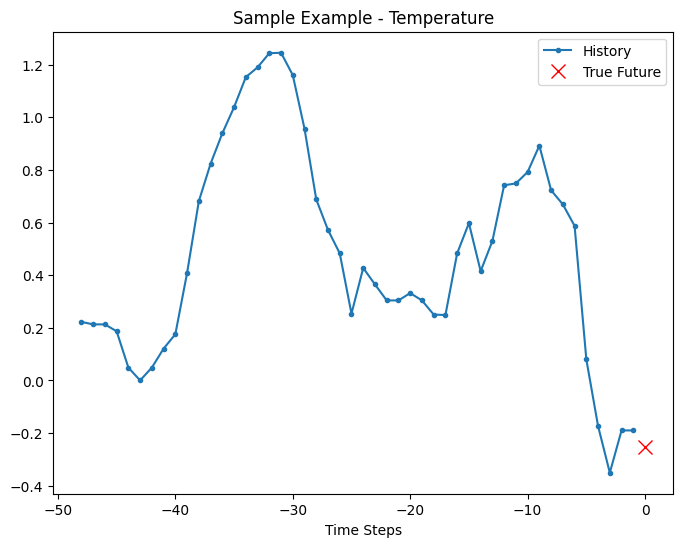

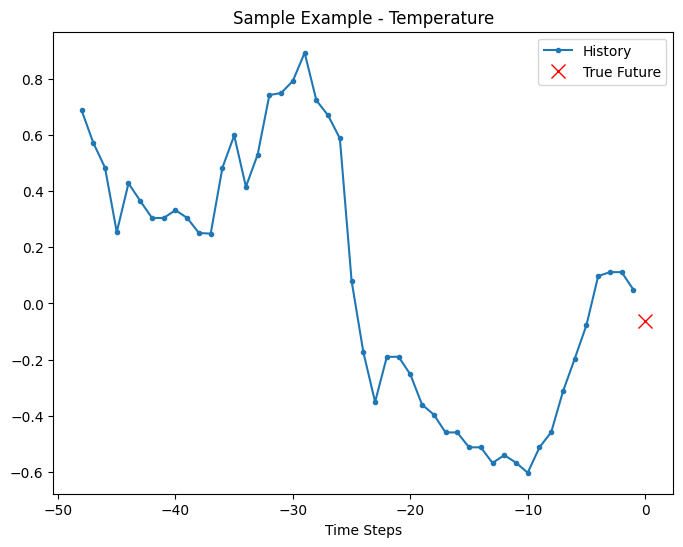

In [50]:
# # Function to create data for univariate forecasting
# def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
#     data = []
#     labels = []
#     start_idx = start_idx + history_size
#     if end_idx is None:
#         end_idx = len(dataset) - target_size
#     for i in range(start_idx, end_idx):
#         idxs = range(i - history_size, i)
#         data.append(dataset[idxs])
#         labels.append(dataset[i + target_size])
#     return np.array(data), np.array(labels)

# uni_data_history = 48 # Last 20 values
# uni_data_future = 0    # Future data
# Function to create data for univariate forecasting
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
    for i in range(start_idx, end_idx):
        # Extract historical data as a sequence
        history = dataset[i - history_size:i]
        data.append(history)
        # Target is the value at the end of the forecast horizon
        labels.append(dataset[i + target_size - 1])
    return np.array(data), np.array(labels)

# Parameters
uni_data_history = 48  # Number of historical time steps
uni_data_future = 1    # Forecast horizon (number of steps ahead to predict)

# Create training and validation data
x_train_uni_temp, y_train_uni_temp = univariate_data(uni_data_temp[:train_split], 0, train_split, uni_data_history, uni_data_future)
x_val_uni_temp, y_val_uni_temp = univariate_data(uni_data_temp[train_split:], 0, None, uni_data_history, uni_data_future)

# Check the shape of the data
print("Shape of x_train_uni_temp:", x_train_uni_temp.shape)
print("Shape of y_train_uni_temp:", y_train_uni_temp.shape)
print("Shape of x_val_uni_temp:", x_val_uni_temp.shape)
print("Shape of y_val_uni_temp:", y_val_uni_temp.shape)


# x_train_uni_temp, y_train_uni_temp = univariate_data(uni_data_temp, 0, train_split, uni_data_history, uni_data_future)
# x_val_uni_temp, y_val_uni_temp = univariate_data(uni_data_temp, train_split, None, uni_data_history, uni_data_future)

print(x_train_uni_temp.shape)  # (151495, 20, 4)
print(y_train_uni_temp.shape)  # (151495, 4)
print(x_val_uni_temp.shape)    # (37859, 20, 4)
print(y_val_uni_temp.shape)    # (37859, 4)

# Function to create time steps
def create_time_steps(length):
    return list(range(-length, 0))

# Function to plot time series data
def plot_time_series(plot_data, delta, title):
    labels = ["History", "True Future", "Model Predicted"]
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i == 0:
            plt.plot(time_steps, plot_data[i][:, 0], marker[i], label=labels[i])  # Plot only the first feature for simplicity
        else:
            future = time_steps[-1] + 1
            plt.plot([future], plot_data[i], marker[i], markersize=10, label=labels[i])  # Plot single future point
    plt.legend()
    plt.xlabel('Time Steps')
    plt.show()

# Example of plotting the first sample
plot_time_series([x_train_uni_temp[0], y_train_uni_temp[0][0]], 0, 'Sample Example - Temperature')

# Example of plotting another sample
i = 20
plot_time_series([x_train_uni_temp[i], y_train_uni_temp[i][0]], 0, 'Sample Example - Temperature')



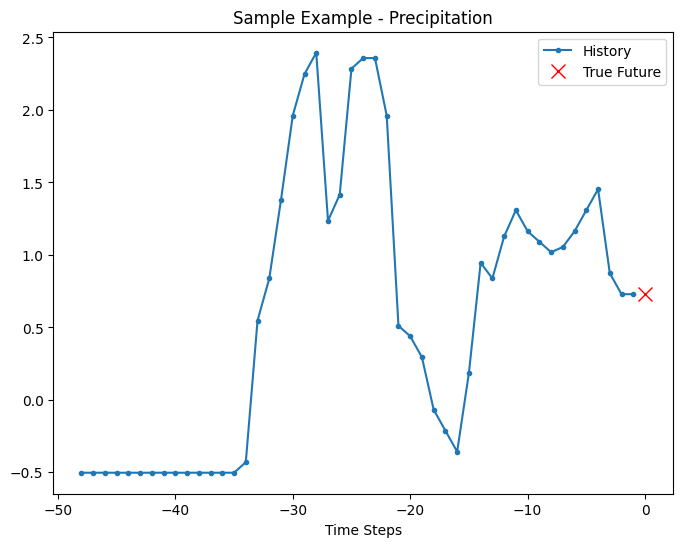

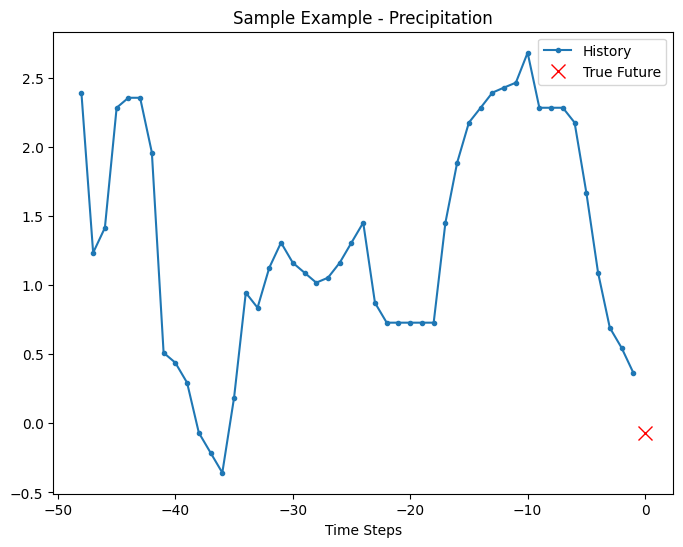

In [51]:
# Prepare the univar# Define the columns for precipitation forecasts
precipitation_cols =['poprecipitation_forecast+{}h'.format(i) for i in range(48)]
# Extract precipitation forecast features
precipitation_features = dfP[precipitation_cols]

scaler_precip = StandardScaler()
uni_data_precip = scaler_precip.fit_transform(precipitation_features.values)

# Assuming train_split is already defined appropriately
tf.random.set_seed(13)


# # Standardize data
# uni_data_precip_mean = uni_data_precip[:train_split].mean(axis=0)
# uni_data_precip_std = uni_data_precip[:train_split].std(axis=0)
# uni_data_precip = (uni_data_precip - uni_data_precip_mean) / uni_data_precip_std

x_train_uni_precip, y_train_uni_precip= univariate_data(uni_data_precip[:train_split], 0, train_split, uni_data_history, uni_data_future)
x_val_uni_precip, y_val_uni_precip= univariate_data(uni_data_precip[train_split:], 0, None, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, 0, train_split, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, train_split, None, uni_data_history, uni_data_future)
x_train_uni_precip.shape, y_train_uni_precip.shape
x_val_uni_precip.shape, y_val_uni_precip.shape

plot_time_series([x_train_uni_precip[0], y_train_uni_precip[0][0]], 0, 'Sample Example - Precipitation')
i = 20
plot_time_series([x_train_uni_precip[i], y_train_uni_precip[i][0]], 0, 'Sample Example - Precipitation')


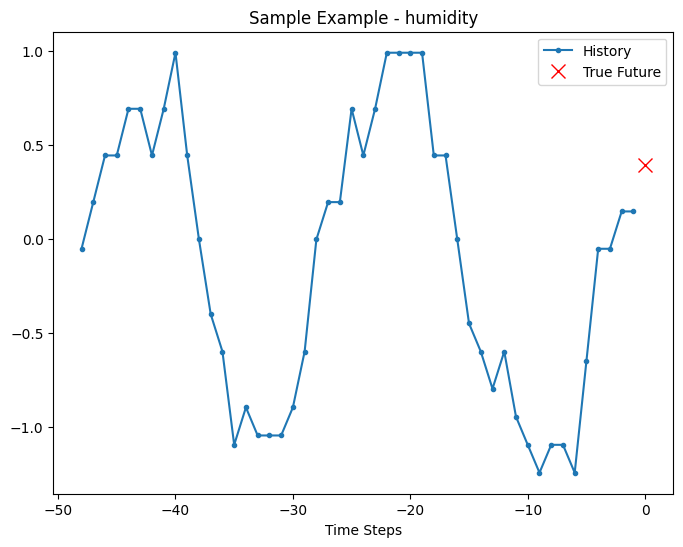

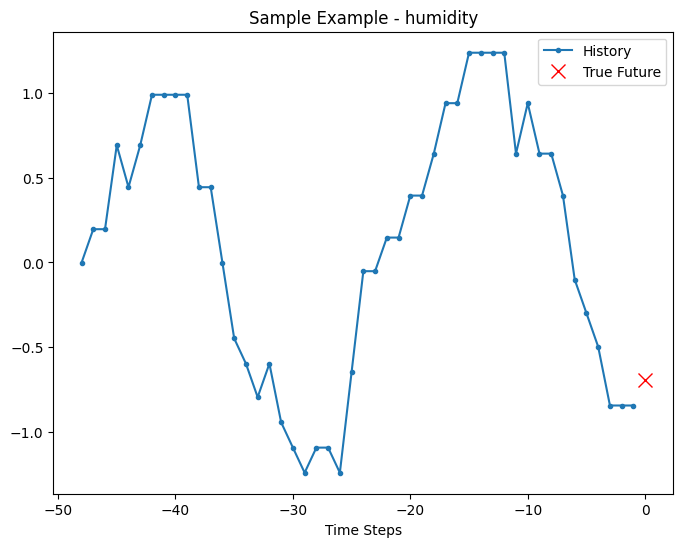

In [53]:
humidity_cols = ['humidity_forecast+{}h'.format(i) for i in range(48)]
humidity_features = dfH[humidity_cols]

scaler_humid = StandardScaler()
uni_data_humid = scaler_humid.fit_transform(humidity_features.values)

# Assuming train_split is already defined appropriately
tf.random.set_seed(13)


# # Standardize data
# uni_data_precip_mean = uni_data_precip[:train_split].mean(axis=0)
# uni_data_precip_std = uni_data_precip[:train_split].std(axis=0)
# uni_data_precip = (uni_data_precip - uni_data_precip_mean) / uni_data_precip_std
x_train_uni_humid, y_train_uni_humid= univariate_data(uni_data_humid[:train_split], 0, train_split, uni_data_history, uni_data_future)
x_val_uni_humid, y_val_uni_humid= univariate_data(uni_data_humid[train_split:], 0, None, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_humid, 0, train_split, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_humid, train_split, None, uni_data_history, uni_data_future)
x_train_uni_humid.shape, y_train_uni_humid.shape
x_val_uni_humid.shape, y_val_uni_humid.shape

plot_time_series([x_train_uni_humid[0], y_train_uni_humid[0][0]], 0, 'Sample Example - humidity')
i = 20
plot_time_series([x_train_uni_humid[i], y_train_uni_humid[i][0]], 0, 'Sample Example - humidity')


In [54]:
# Prepare tensorflow dataset for univariate temperature model
batch_size = 64
buffer_size = 10000

train_uni_temp = tf.data.Dataset.from_tensor_slices((x_train_uni_temp, y_train_uni_temp))
train_uni_temp = train_uni_temp.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_temp = tf.data.Dataset.from_tensor_slices((x_val_uni_temp, y_val_uni_temp))
val_uni_temp = val_uni_temp.cache().shuffle(buffer_size).batch(batch_size).repeat()

# # Prepare tensorflow dataset for univariate precipitation model
train_uni_precip = tf.data.Dataset.from_tensor_slices((x_train_uni_precip, y_train_uni_precip))
train_uni_precip = train_uni_precip.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_precip = tf.data.Dataset.from_tensor_slices((x_val_uni_precip, y_val_uni_precip))
val_uni_precip = val_uni_precip.cache().shuffle(buffer_size).batch(batch_size).repeat()

train_uni_humid = tf.data.Dataset.from_tensor_slices((x_train_uni_humid, y_train_uni_humid))
train_uni_humid= train_uni_humid.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_humid = tf.data.Dataset.from_tensor_slices((x_val_uni_humid, y_val_uni_humid))
val_uni_humid = val_uni_humid.cache().shuffle(buffer_size).batch(batch_size).repeat()


In [ ]:
pip install wandb
import wandb
from wandb.keras import WandbCallback

# Initialize W&B
wandb.init(project="time-series-forecasting", entity="Open_weather", name="LSTM-TimeSeries")


In [55]:
# # Define LSTM model for temperature
# lstm_model_temp = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(8, input_shape=x_train_uni_temp.shape[-2:]),
#     tf.keras.layers.Dense(1)
# ])

# # Compile the model with optimizer and loss function
# lstm_model_temp.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3, weight_decay=1e-5),
#                         loss='mae')
lstm_model_temp = tf.keras.models.Sequential()
lstm_model_temp.add(tf.keras.layers.LSTM(16, return_sequences=True,input_shape = x_train_uni_temp.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(16,return_sequences=False))
# single_step_model.add(tf.keras.layers.Dense(4, activation="relu"))
lstm_model_temp.add(tf.keras.layers.Dense(1))
lstm_model_temp.compile(optimizer = tf.keras.optimizers.Adam(clipvalue=1.0,weight_decay=1e-6), loss = 'mae')
lstm_model_temp.summary()
# # Print model summary
# lstm_model_temp.summary()

# Train LSTM model for temperature
EVALUATION_INTERVAL = 200
EPOCHS = 20

temp_history = lstm_model_temp.fit(train_uni_temp, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                   validation_data=val_uni_temp, validation_steps=50,callbacks=[WandbCallback()])


/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 48, 16)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177 (16.32 KB)

 Trainable params: 4,177 (16.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3034 - val_loss: 0.1410
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1796 - val_loss: 0.1213
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1600 - val_loss: 0.1152
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1508 - val_loss: 0.1105
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1413 - val_loss: 0.1090
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1251 - val_loss: 0.1077
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1206 - val_loss: 0.1102
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1182 - val_loss: 0.1076
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1171 - val_loss: 0.1055
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1142 - val_loss: 0.1040
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1119 - val_loss: 0.1052
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

In [56]:

# Evaluate the model on validation data
from sklearn.metrics import mean_squared_error
mae_lstm_single_temp = lstm_model_temp.evaluate(val_uni_temp, steps=100)
print(f"Mean Absolute Error (MAE): {mae_lstm_single_temp}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1042
Mean Absolute Error (MAE): 0.10350866615772247


In [60]:
# # Define LSTM model for precipitation
# lstm_model_precip = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(32, input_shape=x_train_uni_precip.shape[-2:]),
#     tf.keras.layers.Dense(1)
# ])


lstm_model_precip = tf.keras.models.Sequential()
lstm_model_precip.add(tf.keras.layers.LSTM(16, return_sequences=True,input_shape = x_train_uni_precip.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(16,return_sequences=False))
# single_step_model.add(tf.keras.layers.Dense(4, activation="relu"))
lstm_model_precip.add(tf.keras.layers.Dense(1))
lstm_model_precip.compile(optimizer = tf.keras.optimizers.Adam(clipvalue=1.0,weight_decay=1e-6), loss = 'mae')
lstm_model_precip.summary()

# Train LSTM model for precipitation
precip_history = lstm_model_precip.fit(train_uni_precip, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                       validation_data=val_uni_precip, validation_steps=50,callbacks=[WandbCallback()])


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 48, 16)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 48, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177 (16.32 KB)

 Trainable params: 4,177 (16.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5141 - val_loss: 0.3930
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3628 - val_loss: 0.3684
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3293 - val_loss: 0.3703
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3166 - val_loss: 0.3640
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3012 - val_loss: 0.3693
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2760 - val_loss: 0.3626
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2729 - val_loss: 0.3528
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2683 - val_loss: 0.3633
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2695 - val_loss: 0.3616
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2642 - val_loss: 0.3609
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2682 - val_loss: 0.3618
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

In [58]:

# Evaluate the model on validation data
from sklearn.metrics import mean_squared_error
mae_lstm_single_precip = lstm_model_precip.evaluate(val_uni_precip, steps=100)
print(f"Mean Absolute Error (MAE): {mae_lstm_single_precip}")



100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3717
Mean Absolute Error (MAE): 0.37059035897254944


In [59]:
# Define LSTM model for humidity
lstm_model_humid = tf.keras.models.Sequential()
lstm_model_humid.add(tf.keras.layers.LSTM(16, return_sequences=True,input_shape = x_train_uni_humid.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(16,return_sequences=False))
# single_step_model.add(tf.keras.layers.Dense(4, activation="relu"))
lstm_model_humid.add(tf.keras.layers.Dense(1))
lstm_model_humid.compile(optimizer = tf.keras.optimizers.Adam(clipvalue=1.0,weight_decay=1e-6), loss = 'mae')
lstm_model_humid.summary()
# Train LSTM model for precipitation
humid_history = lstm_model_humid.fit(train_uni_humid, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                       validation_data=val_uni_humid, validation_steps=50,callbacks=[WandbCallback()])


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 48, 16)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 48, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177 (16.32 KB)

 Trainable params: 4,177 (16.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5304 - val_loss: 0.2961
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3581 - val_loss: 0.2681
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3216 - val_loss: 0.2557
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3109 - val_loss: 0.2590
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2991 - val_loss: 0.2499
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2891 - val_loss: 0.2481
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2832 - val_loss: 0.2650
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2670 - val_loss: 0.2548
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2612 - val_loss: 0.2482
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2589 - val_loss: 0.2517
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2554 - val_loss: 0.2521
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

In [27]:

# Evaluate the model on validation data
from sklearn.metrics import mean_squared_error
mae_lstm_single_humid = lstm_model_humid.evaluate(val_uni_humid, steps=100)
print(f"Mean Absolute Error (MAE): {mae_lstm_single_humid}")



100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2451
Mean Absolute Error (MAE): 0.24412882328033447


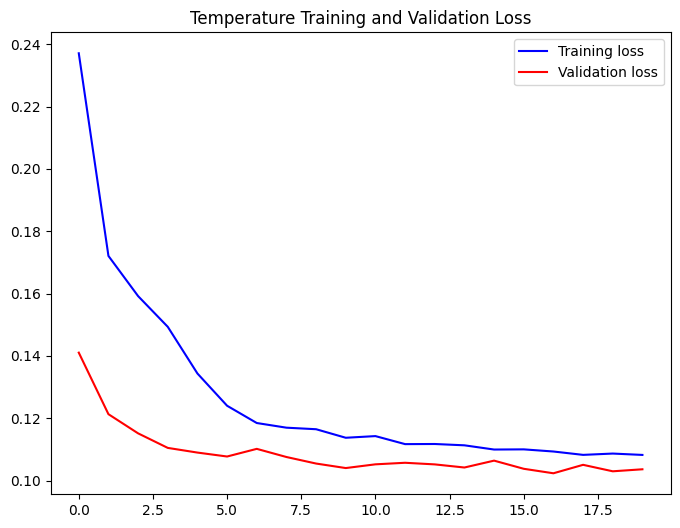

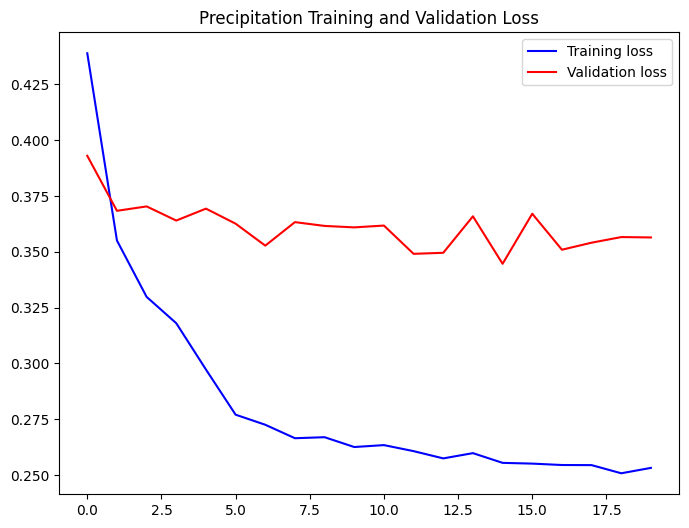

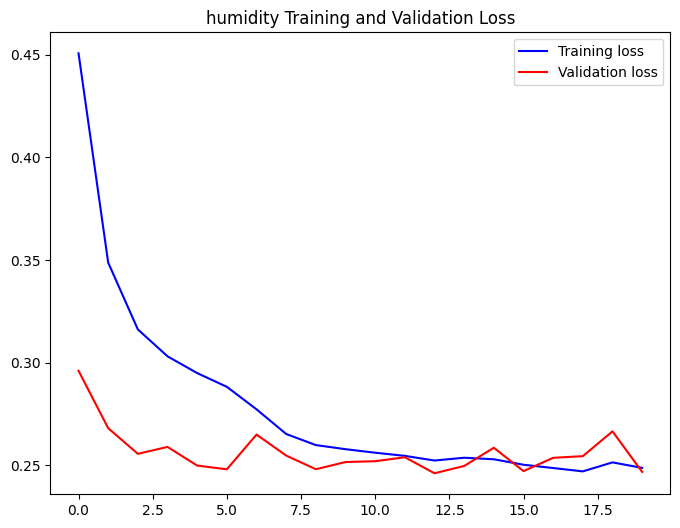

In [61]:
# Plotting function for training history
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(temp_history, 'Temperature Training and Validation Loss')
plot_train_history(precip_history, 'Precipitation Training and Validation Loss')
plot_train_history(humid_history, 'humidity Training and Validation Loss')



In [ ]:
# Save and log temperature model
temp_model_path = "lstm_model_temp.h5"
lstm_model_temp.save(temp_model_path)
wandb.save(temp_model_path)

# Save and log precipitation model
precip_model_path = "lstm_model_precip.h5"
lstm_model_precip.save(precip_model_path)
wandb.save(precip_model_path)

# Save and log humidity model
humid_model_path = "lstm_model_humid.h5"
lstm_model_humid.save(humid_model_path)
wandb.save(humid_model_path)


In [ ]:
# Log the evaluation metrics
wandb.log({"MAE Temperature": mae_lstm_single_temp})
wandb.log({"MAE Precipitation": mae_lstm_single_precip})
wandb.log({"MAE Humidity": mae_lstm_single_humid})


In [ ]:
wandb.finish()


In [29]:
df_multi = pd.concat([dfP[precipitation_cols],
                      dfT[temperature_cols],
                      dfH[humidity_cols]], axis=1)
# df_combined = pd.concat(df, axis=1)

/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Model Output Shape: (64, 72)
Target Shape: (64, 72)
Epoch 1/20


2024-08-26 22:24:10.051006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.6925 - val_loss: 0.2905
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.3607 - val_loss: 0.2748
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.3345 - val_loss: 0.2707
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.3102 - val_loss: 0.2679
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.2825 - val_loss: 0.2683
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.2428 - val_loss: 0.2647
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.2226 - val_loss: 0.2535
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.2138 - val_loss: 0.2489
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.2069 - val_loss: 0.2575
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.2041 - val_loss: 0.2716
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.1989 - val_loss: 0.2449
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/st

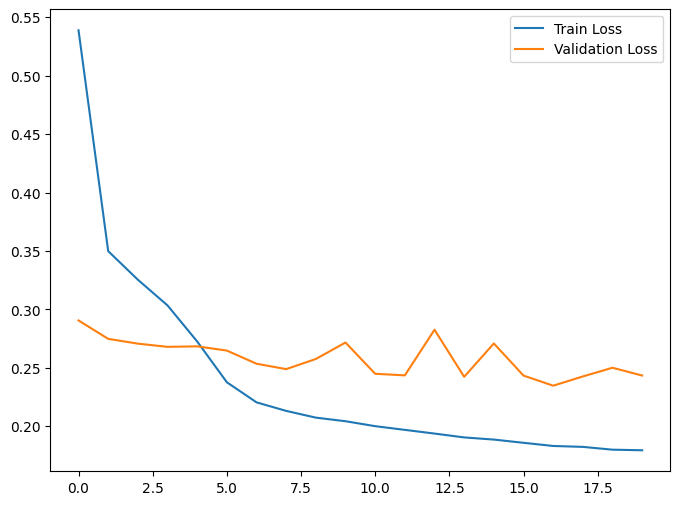

In [75]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Assuming dfP, dfT, and dfH are your DataFrames containing precipitation, temperature, and humidity data respectively
df_multi = pd.concat([dfT[temperature_cols], dfP[precipitation_cols],
                      dfH[humidity_cols]], axis=1)

# Function to create multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    end_index = end_index if end_index is not None else len(dataset) - target_size
    start_index = start_index + history_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])

    return np.array(data), np.array(labels)

# Normalize the features
multi_scaler = StandardScaler()
multi_features = multi_scaler.fit_transform(df_multi)

# Parameters
history_size = 720
target_size = 72
STEP = 6
buffer_size = 10000  # Size of shuffle buffer
batch_size = 64
train_split = int(len(multi_features) * 0.9)  # 90% for training

# Create training and validation data
x_train_multi, y_train_multi = multivariate_data(multi_features, multi_features[:, 0], 0, train_split, history_size, target_size, STEP, single_step=False)
x_val_multi, y_val_multi = multivariate_data(multi_features, multi_features[:, 0], train_split, None, history_size, target_size, STEP, single_step=False)

# Create TensorFlow datasets with caching
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

# Multivariate LSTM model
multi_step_model = Sequential([
    LSTM(16, return_sequences=True, input_shape=x_train_multi.shape[-2:]),
    LSTM(8, activation='relu'),
    Dense(target_size)  # Output layer with the same size as target_size
])

multi_step_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0, weight_decay=1e-6),
    loss='mae'
)

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Verify model output shape
for x, y in val_data_multi.take(1):
    predictions = multi_step_model.predict(x)
    print("Model Output Shape:", predictions.shape)
    print("Target Shape:", y.shape)

# Define training parameters
EVALUATION_INTERVAL = 200
EPOCHS = 20

# Train the model with Early Stopping
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi, validation_steps=50,
                                          callbacks=[WandbCallback()])

# Plotting training history
plt.plot(multi_step_history.history['loss'], label='Train Loss')
plt.plot(multi_step_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


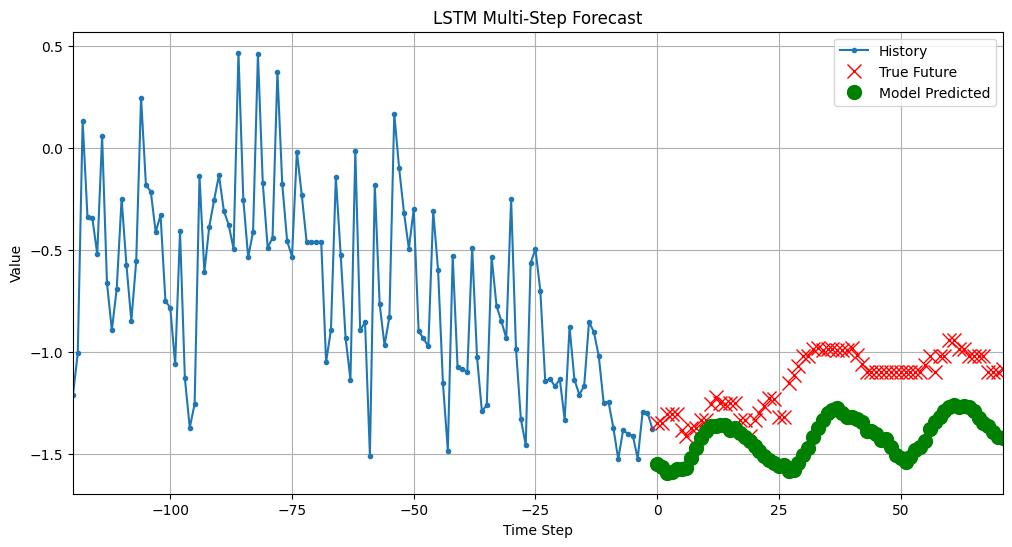

2024-08-26 22:26:48.114325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [76]:
# Function to create time steps
def create_time_steps(length):
    return list(range(-length, 0))

# Function to plot time series data
def plot_time_series(plot_data, delta, title):
    labels = ["History", 'True Future', 'Model Predicted']
    markers = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if isinstance(x, tf.Tensor):
            x = x.numpy()
        x = x.flatten()
        
        if i == 0:
            plt.plot(time_steps, x, markers[i], label=labels[i])
        else:
            # Adjust plotting to match the time steps
            plt.plot(range(len(x)), x, markers[i], markersize=10, label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], len(x) - 1])
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Plot some predictions
for x, y in val_data_multi.take(1):
    y_pred = multi_step_model.predict(x)
    plot_time_series([x[0][:, 0], y[0], y_pred[0]], 0, 'LSTM Multi-Step Forecast')


In [77]:
# Evaluate the model on validation data
from sklearn.metrics import mean_squared_error
mae_lstm_multi = multi_step_model.evaluate(val_data_multi, steps=100)
print(f"Mean Absolute Error (MAE): {mae_lstm_multi}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2345
Mean Absolute Error (MAE): 0.23459982872009277


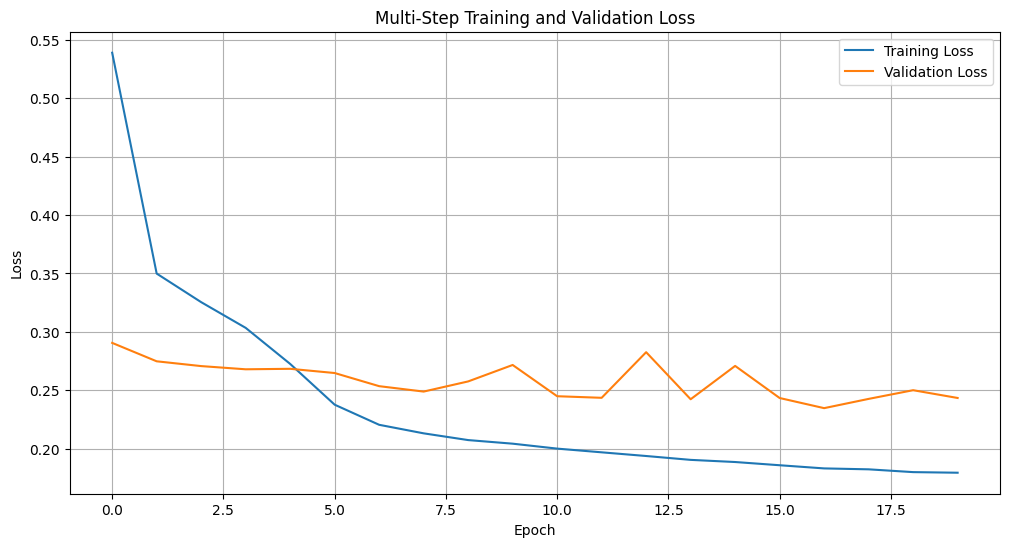

In [78]:
# Function to plot training history
def plot_train_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot training history
plot_train_history(multi_step_history, 'Multi-Step Training and Validation Loss')
